In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.stats as st
import pandas as pd
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import RidgeCV
import mrmr
from mrmr import mrmr_classif
from sklearn.metrics import jaccard_score
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
# Read in data
signal = pd.read_csv('Data/signal_train.csv').dropna(axis=1)
background = pd.read_csv('Data/background_train.csv').dropna(axis=1)

# Remove columns which aren't the same in signal and background
diff_labels_sig = np.setdiff1d(signal.columns, background.columns)
signal = signal.drop(diff_labels_sig, axis=1)
diff_labels_bg = np.setdiff1d(background.columns, signal.columns)
background = background.drop(diff_labels_bg, axis=1)

# Remove columns with Monte Carlo truths
remove_labels = [k for k in signal.columns if 'Weight' in k or 'MC' in k or 'Corsika' in k or 'I3EventHeader' in k]
signal = signal.drop(remove_labels, axis=1)
background = background.drop(remove_labels, axis=1)

# Deal with NaNs by setting to large negative number
'''MAY BE BETTER TO USE AN INTERPOLATION OF MISSING VALUES?'''
signal = signal.fillna(-1e30)
background = background.fillna(-1e30)

# Extract the labels used for validation
sig_labels = signal['label']
signal = signal.drop('label',axis=1)
bg_labels = background['label']
background = background.drop('label',axis=1)

signal.head()

,HitMultiplicityValues.n_hit_strings,HitMultiplicityValues.n_hit_doms,HitMultiplicityValues.n_hit_doms_one_pulse,HitStatisticsValues.cog_z_sigma,HitStatisticsValues.min_pulse_time,HitStatisticsValues.max_pulse_time,HitStatisticsValues.q_max_doms,HitStatisticsValues.z_min,HitStatisticsValues.z_max,HitStatisticsValues.z_mean,...,SplineMPETruncatedEnergy_SPICEMie_AllDOMS_Muon.type,SplineMPETruncatedEnergy_SPICEMie_AllDOMS_Muon.fit_status,NewID,NewAtt.radius,NewAtt.DirectEllipse,NewAtt.DeltaZd,NewAtt.emptyness,NewAtt.SepDevide,NewAtt.SPEBayVerRadius,NewAtt.SplineVerRadius
0,18.0,61.0,51.0,56.918818,9620.149414,12554.148438,13.438909,-469.140015,-149.070007,-316.056395,...,0.0,0.0,64.0,147.780226,44.468594,0.056349,1.0,0.817921,281.014746,176.054897
1,4.0,17.0,12.0,107.009602,9424.810547,10866.173828,3.103700,-504.160004,-145.589996,-303.344118,...,0.0,0.0,314.0,366.974384,39.249526,0.025288,1.0,0.581986,425.929142,379.645109
2,7.0,19.0,16.0,33.235703,9870.542969,12140.942383,7.148956,78.580002,227.500000,135.803158,...,0.0,0.0,488.0,265.063779,44.492746,0.001074,1.0,1.101785,236.851388,294.405333
3,10.0,20.0,16.0,110.222554,9793.984375,12979.283203,1.960272,-485.540009,-129.229996,-324.374998,...,0.0,0.0,605.0,240.998469,23.536249,0.054007,1.0,2.058378,648.741666,218.159001
4,6.0,19.0,14.0,21.467337,14054.889648,16228.914062,2.931422,158.130005,257.640015,208.761580,...,0.0,0.0,785.0,444.019109,43.249092,0.039559,1.0,1.092478,498.886826,436.369962


In [3]:
'''NEED TO COMBINE SIGNAL AND BACKGROUND DATA TO TELL WHICH FEATURES BEST DISTINGUISH'''
all_data = pd.concat([signal,background])
labels = pd.concat([sig_labels,bg_labels])

In [14]:
# Forward Selection
ridge = RidgeCV(alphas=np.logspace(-6, 6, num=5)).fit(all_data, labels)
importance = np.abs(ridge.coef_)
feature_names = np.array(signal.columns)

sfs_forward = SequentialFeatureSelector(
    ridge, n_features_to_select=4, direction="forward"
).fit(all_data, labels)

FwdSel_features = feature_names[sfs_forward.get_support()]

print("Features selected by forward sequential selection: "
    f"{FwdSel_features}")

Features selected by forward sequential selection: ['LineFit_TTParams.lf_vel' 'SPEFit2Bayesian.z'
 'SplineMPECharacteristics.avg_dom_dist_q_tot_dom'
 'SplineMPEFitParams.rlogl']


In [15]:
train = all_data[FwdSel_features]

In [16]:
#FwdSel Naive Bayes
clf = GaussianNB()
clf.fit(train, labels)
predicted_labels = clf.predict(train)

# Jaccard Score
print(jaccard_score(labels, predicted_labels))

0.7051806407634629


In [17]:
#FwdSel RandomForest
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(train, labels)
predicted_labels = clf.predict(train)

# Jaccard Score
print(jaccard_score(labels, predicted_labels))

0.6059326506914389


In [18]:
#FwdSel KNN
clf = KNeighborsClassifier()
clf.fit(train, labels)
predicted_labels = clf.predict(train)

# Jaccard Score
print(jaccard_score(labels, predicted_labels))

0.7749287749287749


In [25]:
def set_fwd_sel (n) :
    ridge = RidgeCV(alphas=np.logspace(-6, 6, num=5)).fit(all_data, labels)
    importance = np.abs(ridge.coef_)
    feature_names = np.array(signal.columns)
    
    sfs_forward = SequentialFeatureSelector(
        ridge, n_features_to_select=n, direction="forward"
    ).fit(all_data, labels)
    
    FwdSel_features = feature_names[sfs_forward.get_support()]
    return FwdSel_features

def optimiseFeatures_FwdSel(all_data, labels,clf):
    kmax = 15
    J = np.zeros(kmax)
    for k in range(1,kmax):
        FwdSel_features = set_fwd_sel(k)
        train = all_data[FwdSel_features]
        clf.fit(train, labels)
        predicted_labels = clf.predict(train)
        J[k] = jaccard_score(labels, predicted_labels)
    plt.plot(J[1:],)
    print('Best Jacard Score:',np.max(J),'with k =',np.argmax(J))
    return J

Best Jacard Score: 0.7051806407634629 with k = 4


array([0.        , 0.58659338, 0.62458213, 0.67794362, 0.70518064,
       0.67429766, 0.56245769, 0.60603062, 0.63790169, 0.66284241,
       0.66472157, 0.66179804, 0.66923936, 0.67094947, 0.66404715])

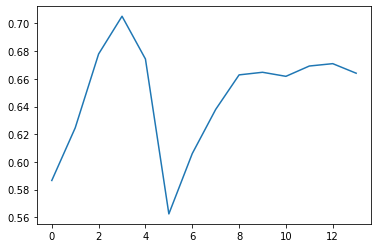

In [26]:
optimiseFeatures_FwdSel(all_data,labels,clf=GaussianNB())

Best Jacard Score: 0.7310955538040707 with k = 8


array([0.        , 0.52936926, 0.57858074, 0.70553408, 0.60593265,
       0.65655082, 0.65987039, 0.72262286, 0.73109555, 0.7084399 ,
       0.71954413, 0.7058531 , 0.7190258 , 0.72635248, 0.71656363])

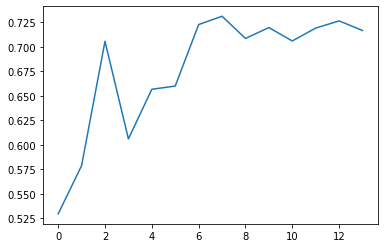

In [27]:
optimiseFeatures_FwdSel(all_data,labels,clf=RandomForestClassifier(max_depth=2, random_state=0))

Best Jacard Score: 0.8294812532100667 with k = 11


array([0.        , 0.65278178, 0.68884587, 0.77466726, 0.77492877,
       0.77831242, 0.77828549, 0.80014135, 0.81476408, 0.81494824,
       0.81517934, 0.82948125, 0.82226533, 0.82226533, 0.82250574])

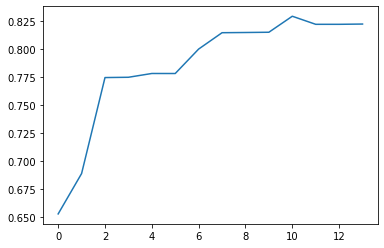

In [28]:
optimiseFeatures_FwdSel(all_data,labels,clf=KNeighborsClassifier())

In [7]:
# mRMR
mRMR_features = mrmr_classif(X=all_data, y=labels, K=4)
print(mRMR_features)

100%|██████████| 4/4 [00:00<00:00,  5.49it/s]

['LineFit_TTParams.lf_vel_z', 'SplineMPEDirectHitsC.n_dir_strings', 'HitStatisticsValues.z_travel', 'SplineMPEFitParams.rlogl']


In [8]:
# Select recommended features for machine learning algorithms
train = all_data[mRMR_features]

In [9]:
# Naive Bayes
clf = GaussianNB()
clf.fit(train, labels)
predicted_labels = clf.predict(train)

# Jaccard Score
print(jaccard_score(labels, predicted_labels))

0.6926542103916048


In [12]:
# RandomForest
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(train, labels)
predicted_labels = clf.predict(train)

# Jaccard Score
print(jaccard_score(labels, predicted_labels))

0.765777296445801


In [11]:
# KNN
clf = KNeighborsClassifier()
clf.fit(train, labels)
predicted_labels = clf.predict(train)

# Jaccard Score
print(jaccard_score(labels, predicted_labels))

0.8194919647485744


In [29]:
def optimiseFeatures_mRMR(all_data, labels,clf):
    kmax = 15
    J = np.zeros(kmax)
    for k in range(1,kmax):
        mRMR_features = mrmr_classif(X=all_data, y=labels, K=k);
        train = all_data[mRMR_features]
        clf.fit(train, labels)
        predicted_labels = clf.predict(train)
        J[k] = jaccard_score(labels, predicted_labels)
    plt.plot(J[1:],)
    print('Best Jacard Score:',np.max(J),'with k =',np.argmax(J))
    return J

100%|██████████| 14/14 [00:02<00:00,  4.78it/s]

Best Jacard Score: 0.7150680724741529 with k = 11


array([0.        , 0.60195093, 0.65820962, 0.66497668, 0.69265421,
       0.70966408, 0.68861821, 0.7127638 , 0.6964959 , 0.70513208,
       0.68905921, 0.71506807, 0.71469593, 0.70584634, 0.70989953])

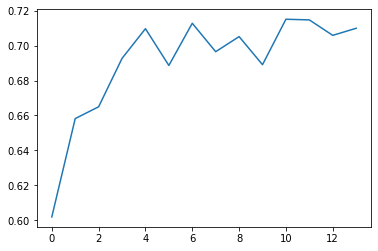

In [30]:
optimiseFeatures_mRMR(all_data,labels,clf = GaussianNB())

100%|██████████| 14/14 [00:02<00:00,  4.68it/s]


Best Jacard Score: 0.7788798420922773 with k = 11


array([0.        , 0.70421834, 0.74268175, 0.75364024, 0.7657773 ,
       0.7644915 , 0.76939509, 0.77484548, 0.767468  , 0.77185812,
       0.76924574, 0.77887984, 0.77762163, 0.77044239, 0.77282502])

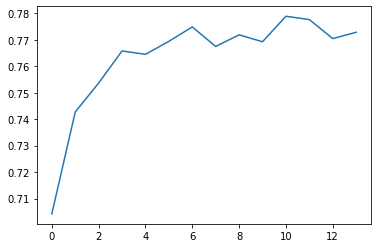

In [31]:
optimiseFeatures_mRMR(all_data,labels,clf = RandomForestClassifier(max_depth=2, random_state=0))

100%|██████████| 14/14 [00:02<00:00,  4.88it/s]


Best Jacard Score: 0.8528597545050927 with k = 8


array([0.        , 0.74209463, 0.80251364, 0.79724895, 0.81949196,
       0.84569191, 0.84670315, 0.85275368, 0.85285975, 0.82929702,
       0.82920336, 0.82953556, 0.83564112, 0.83554663, 0.83620381])

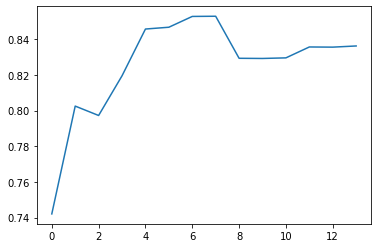

In [32]:
optimiseFeatures_mRMR(all_data,labels,clf = KNeighborsClassifier())

In [4]:
# Select recommended features for machine learning algorithms
mRMR_features = mrmr_classif(X=all_data, y=labels, K=7)
print(mRMR_features)
train = all_data[mRMR_features]

100%|██████████| 7/7 [00:01<00:00,  5.32it/s]

['LineFit_TTParams.lf_vel_z', 'SplineMPEDirectHitsC.n_dir_strings', 'HitStatisticsValues.z_travel', 'SplineMPEFitParams.rlogl', 'SplineMPECharacteristics.avg_dom_dist_q_tot_dom', 'LineFit_TT.zenith', 'SplineMPEDirectHitsA.n_dir_strings']


In [72]:
# Naive Bayes
clf = GaussianNB()
clf.fit(train, labels)
NBC_probs = clf.predict_proba(train)
NBC_preds = clf.predict(train)
print(NBC_probs[:10])

[[1.48496681e-03 9.98515033e-01]
 [4.11049375e-07 9.99999589e-01]
 [9.88642897e-01 1.13571032e-02]
 [4.69708867e-01 5.30291133e-01]
 [4.12032149e-01 5.87967851e-01]
 [5.24274968e-06 9.99994757e-01]
 [5.25110431e-06 9.99994749e-01]
 [2.40148909e-06 9.99997599e-01]
 [5.64253313e-03 9.94357467e-01]
 [1.46504724e-02 9.85349528e-01]]


In [73]:
# Random Forest Classifier
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(train, labels)
RFC_probs = clf.predict_proba(train)
RFC_preds = clf.predict(train)
print(RFC_probs[:10])

[[0.13056948 0.86943052]
 [0.24692307 0.75307693]
 [0.80565442 0.19434558]
 [0.33433651 0.66566349]
 [0.77414739 0.22585261]
 [0.14452145 0.85547855]
 [0.09680754 0.90319246]
 [0.47543485 0.52456515]
 [0.16544777 0.83455223]
 [0.15764038 0.84235962]]


In [74]:
# KNN Classifier
clf = KNeighborsClassifier()
clf.fit(train, labels)
KNN_probs = clf.predict_proba(train)
KNN_preds = clf.predict(train)
print(KNN_probs[:10])

[[0.  1. ]
 [0.  1. ]
 [0.2 0.8]
 [0.4 0.6]
 [0.2 0.8]
 [0.  1. ]
 [0.  1. ]
 [0.  1. ]
 [0.  1. ]
 [0.  1. ]]


[0.00000000e+00 8.30242984e-04 8.85592517e-04 ... 9.96014834e-01
 9.96014834e-01 1.00000000e+00] [0.         0.05369988 0.05838398 ... 0.99994424 1.         1.        ] [           inf 1.00000000e+00 1.00000000e+00 ... 3.38232872e-05
 3.29998632e-05 1.94677595e-07]


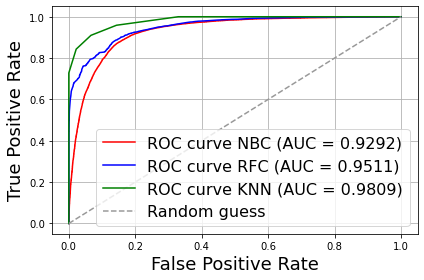

In [27]:
fp1, tp1, thresholds1 = roc_curve(labels,NBC_probs[:,1])
fp2, tp2, thresholds2 = roc_curve(labels,RFC_probs[:,1])
fp3, tp3, thresholds3 = roc_curve(labels,KNN_probs[:,1])
roc_auc1 = auc(fp1, tp1)
roc_auc2 = auc(fp2, tp2)
roc_auc3 = auc(fp3, tp3)
plt.plot(fp1,tp1,color='red',label='ROC curve NBC (AUC = %0.4f)'%(roc_auc1))
plt.plot(fp2,tp2,color='blue',label='ROC curve RFC (AUC = %0.4f)'%(roc_auc2))
plt.plot(fp3,tp3,color='green',label='ROC curve KNN (AUC = %0.4f)'%(roc_auc3))
plt.xlabel('False Positive Rate',fontsize=18)
plt.ylabel('True Positive Rate',fontsize=18)
plt.plot([0, 1],[0, 1],linestyle='--',color=(0.6, 0.6, 0.6),label='Random guess')
plt.grid()
plt.legend(loc="best",fontsize=16)
plt.tight_layout()
print(fp1,tp1,thresholds1)

In [8]:
# Quality Parameters
def precision(preds, labels):
    conf_matrix = confusion_matrix(labels, preds)
    TN = conf_matrix[0,0]
    FP = conf_matrix[0,1]
    FN = conf_matrix[1,0]
    TP = conf_matrix[1,1]
    return TP/(TP+FP)

def recall(preds, labels):
    conf_matrix = confusion_matrix(labels, preds)
    TN = conf_matrix[0,0]
    FP = conf_matrix[0,1]
    FN = conf_matrix[1,0]
    TP = conf_matrix[1,1]
    return TP/(TP+FN)

def f_beta(p, r, beta=0.1):
    f = (1+beta**2)*(p*r)/(beta**2*p+r)
    return f

In [58]:
def optimise_f(data,labels,classifier,n) :

    p_values = np.zeros(n)
    r_values = np.zeros(n)
    f_values = np.zeros(n)
    thresholds = np.linspace(0,1,n,endpoint=True)

    classifier.fit(train, labels)
    probs = classifier.predict_proba(data)

    for i,threshold in zip(np.arange(n),thresholds) :
        preds = (probs[:, 1] >= threshold).astype(int)
        p = precision(preds,labels)
        r = recall(preds,labels)
        f = f_beta(p,r)

        p_values[i] = p
        r_values[i] = r
        f_values[i] = f

    plt.figure(figsize=(15,10))
    plt.subplot(1,3,1)
    plt.plot(thresholds,p_values)
    plt.subplot(1,3,2)
    plt.plot(thresholds,r_values)
    plt.subplot(1,3,3)
    plt.plot(thresholds,f_values)

    return thresholds, p_values, r_values, f_values

[0.    0.025 0.05  0.075 0.1   0.125 0.15  0.175 0.2   0.225 0.25  0.275
 0.3   0.325 0.35  0.375 0.4   0.425 0.45  0.475 0.5   0.525 0.55  0.575
 0.6   0.625 0.65  0.675 0.7   0.725 0.75  0.775 0.8   0.825 0.85  0.875
 0.9   0.925 0.95  0.975 1.   ] [0.49813889 0.75061739 0.75061739 0.75061739 0.75061739 0.75061739
 0.75061739 0.75061739 0.75061739 0.86896099 0.86896099 0.86896099
 0.86896099 0.86896099 0.86896099 0.86896099 0.86896099 0.93124108
 0.93124108 0.93124108 0.93124108 0.93124108 0.93124108 0.93124108
 0.97410795 0.97410795 0.97410795 0.97410795 0.97410795 0.97410795
 0.97410795 0.97410795 0.97410795 1.         1.         1.
 1.         1.         1.         1.         1.        ] [1.         1.         1.         1.         1.         1.
 1.         1.         1.         0.95884682 0.95884682 0.95884682
 0.95884682 0.95884682 0.95884682 0.95884682 0.95884682 0.91005409
 0.91005409 0.91005409 0.91005409 0.91005409 0.91005409 0.91005409
 0.8433614  0.8433614  0.8433614  0.84

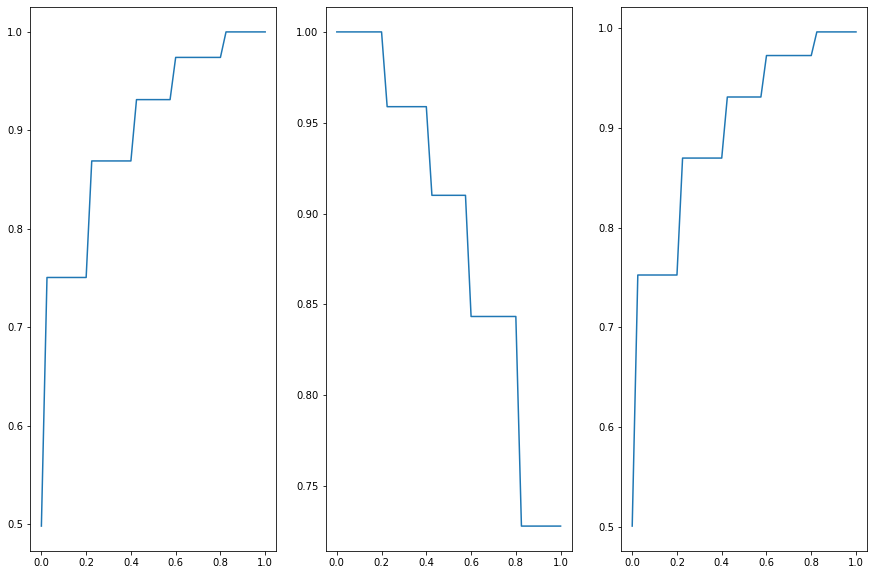

In [71]:
thresholds_knn,p,r,f_knn = optimise_f(train,labels,KNeighborsClassifier(),41)
print(thresholds_knn,p,r,f_knn)

[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ] [0.49813889 0.49813889 0.49813889 0.6600574  0.7210021  0.74468543
 0.7666995  0.78598265 0.80766631 0.83781569 0.86558168 0.87401217
 0.88133004 0.91364938 0.95268254 0.98796631 0.99767029 0.99956281
 1.                nan        nan] [1.         1.         1.         0.98756482 0.97574304 0.96498076
 0.9549434  0.94490604 0.93291697 0.9120058  0.88083422 0.85724642
 0.8365583  0.80064685 0.72977193 0.64094128 0.50147772 0.38247923
 0.16478001 0.         0.        ] [0.50062646 0.50062646 0.50062646 0.66223182 0.72287064 0.74637245
 0.76819882 0.78729369 0.80874135 0.83849103 0.8657301  0.87384296
 0.88086328 0.91237441 0.94981004 0.98269836 0.98799129 0.9838468
 0.95221307        nan        nan]


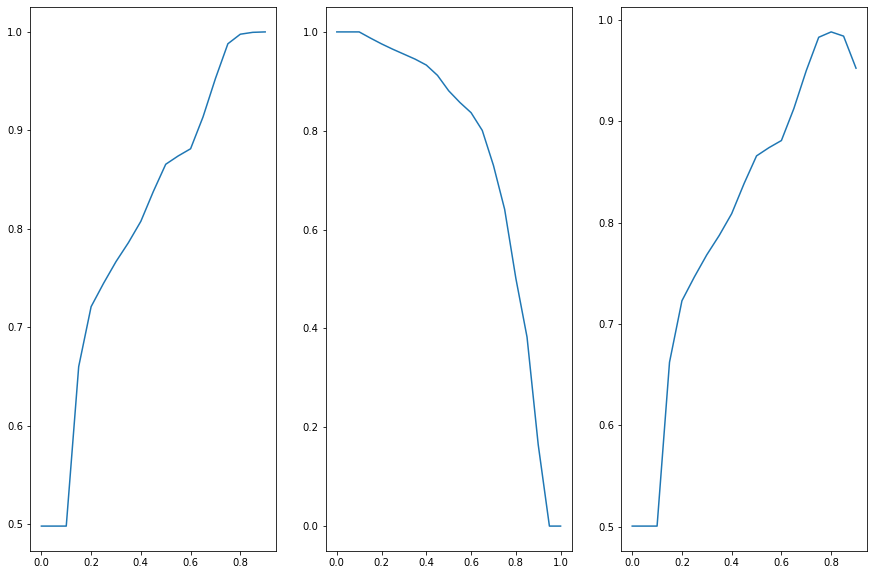

In [65]:
thresholds_rf,p,r,f_rf = optimise_f(train,labels,RandomForestClassifier(max_depth=2, random_state=0),21)
print(thresholds_rf,p,r,f_rf)

[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ] [0.49813889 0.82837831 0.85034271 0.86124269 0.86798075 0.87289971
 0.87609512 0.87904105 0.88219751 0.88595453 0.88761135 0.88992119
 0.89263185 0.89577279 0.89842911 0.90184679 0.9047752  0.90851735
 0.91310478 0.9192639  0.98466258] [1.         0.90893883 0.87860369 0.86181899 0.84469972 0.83142809
 0.81971784 0.80968048 0.80053533 0.79317459 0.78347181 0.77449395
 0.76540456 0.75625941 0.74627781 0.73523671 0.72269001 0.70663023
 0.68616517 0.65460325 0.05369988] [0.50062646 0.82910588 0.8506136  0.86124839 0.86774395 0.87246883
 0.87549894 0.87829611 0.88130739 0.88492965 0.88644474 0.88860996
 0.8911652  0.89413963 0.89661918 0.8998279  0.90252377 0.90595463
 0.91012447 0.91559872 0.84040853]


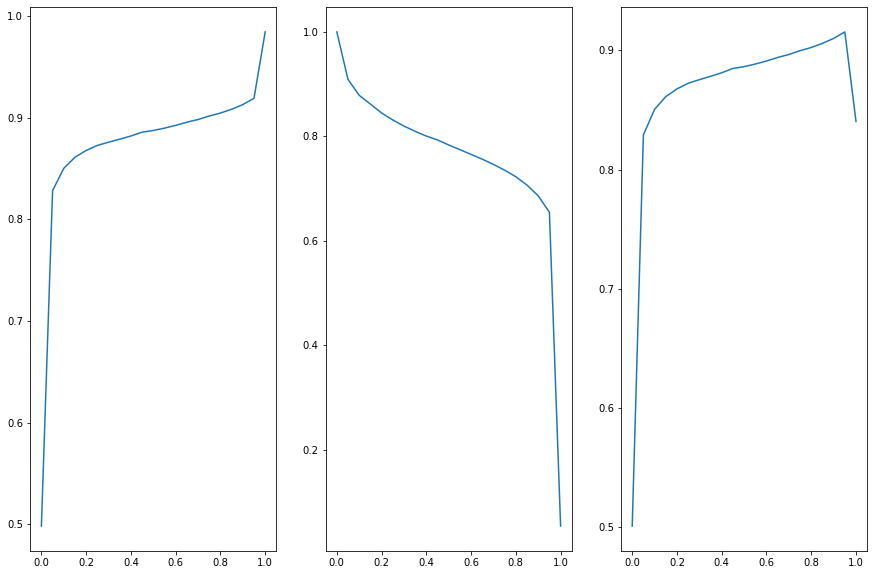

In [66]:
thresholds_nb,p,r,f_nb = optimise_f(train,labels,GaussianNB(),21)
print(thresholds_nb,p,r,f_nb)

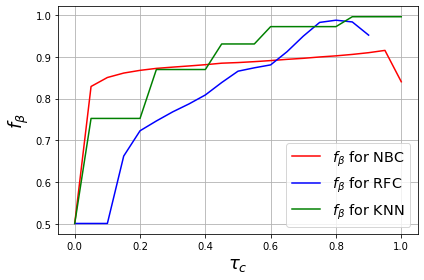

In [69]:
plt.plot(thresholds_nb,f_nb,color='red',label='$f_{\\beta}$ for NBC')
plt.plot(thresholds_rf,f_rf,color='blue',label='$f_{\\beta}$ for RFC')
plt.plot(thresholds_knn,f_knn,color='green',label='$f_{\\beta}$ for KNN')
plt.xlabel('$\\tau_{c}$',fontsize=18)
plt.ylabel('$f_{\\beta}$',fontsize=18)
#plt.plot([0, 1],[0, 1],linestyle='--',color=(0.6, 0.6, 0.6),label='Random guess')
plt.grid()
plt.legend(loc="best",fontsize='x-large')
plt.tight_layout()

In [107]:
threshold = 0.7
NBC_preds = (NBC_probs[:, 1] >= threshold).astype(int)
NB_p = precision(NBC_preds, labels)
NB_r = recall(NBC_preds, labels)
NB_f = f_beta(NB_p, NB_r)
print(NB_p, NB_r, NB_f)

0.8984291084854995 0.7462778118552389 0.8966191784856451


In [108]:
RF_preds = (RFC_probs[:, 1] > threshold).astype(int)
RF_p = precision(RF_preds, labels)
RF_r = recall(RF_preds, labels)
RF_f = f_beta(RF_p, RF_r)
print(RF_p, RF_r, RF_f)

0.9526825362160588 0.7297719288462611 0.9498100433088321


In [109]:
KNN_preds = (KNN_probs[:, 1] > threshold).astype(int)
KNN_p = precision(KNN_preds, labels)
KNN_r = recall(KNN_preds, labels)
KNN_f = f_beta(KNN_p, KNN_r)
print(KNN_p, KNN_r, KNN_f)

0.9741079479582636 0.843361400769531 0.9726150294199486


In [103]:
#Shuffling the data, since the dataset is associated only to backround in the first half and to signal 
#in the second (or vice versa). There's probably a more efficient way to do this, this is the first one I thought of.
def data_shuffling(data,labels) :
    x_train,x_test,y_train,y_test=train_test_split(data,labels,train_size=len(train)-1,shuffle=True,random_state=3)
    data = np.concatenate((np.array(x_train),np.array(x_test)))
    labels = np.concatenate((np.array(y_train),np.array(y_test)))
    return data,labels

#Splitting the data in n samples of equal dimension,
#if the size is not divisible by n, the few excess entries are deleted 
#(It's quite brutal, I know)
def data_splitting(data,labels,n) :    
    if int(len(data)/n)*n != len(data) :
        excess = len(data) - int(len(data)/n)*n
        data = np.delete(data,np.arange(excess),0)
        labels = np.delete(labels,np.arange(excess),0)
    cross_validation_data = data.reshape(n,int(len(data)/n),int(len(mRMR_features)))
    cross_validation_labels = labels.reshape(n,int(len(labels)/n))
    return cross_validation_data,cross_validation_labels

#Performing the cross validation and computing the quality parameters for each iteration
def cross_validation(data,labels,classifier) :
    threshold = 0.7
    precisions = np.zeros(len(data))
    recalls = np.zeros(len(data))
    f_betas = np.zeros(len(data))
    auc_values = np.zeros(len(data))
    fp_rates,tp_rates,thresholds,lengths = [],[],[],[]
    
    for i in range(len(data)) :
        train_labels = np.delete(labels,i,axis=0)
        test_labels = labels[i]
        train_sample = np.delete(data,i,axis=0)
        test_sample = data[i]
    
        train_sample = train_sample.reshape((len(data)-1)*len(train_sample[1]),len(mRMR_features))
        train_labels = train_labels.reshape((len(data)-1)*len(train_labels[1]))
    
        classifier.fit(train_sample,train_labels)
        classifier_probs = classifier.predict_proba(test_sample)
        classifier_preds = (classifier_probs[:, 1] >= threshold).astype(int)

        fp, tp,t = roc_curve(test_labels,classifier_probs[:,1])
        fp_rates.append(fp)
        tp_rates.append(tp)
        thresholds.append(t)
        lengths.append(len(t))

        roc_auc_value = auc(fp, tp)
    
        classifier_p = precision(classifier_preds, test_labels)
        classifier_r = recall(classifier_preds, test_labels)
        classifier_f = f_beta(classifier_p, classifier_r)
    
        precisions[i] = classifier_p
        recalls[i] = classifier_r
        f_betas[i] = classifier_f
        auc_values[i] = roc_auc_value

    min_length = min(lengths)

    for i in range(len(fp_rates)) :
        fp_rates[i] = fp_rates[i][:min_length]
        tp_rates[i] = tp_rates[i][:min_length]
        thresholds[i] = thresholds[i][:min_length]

    fp_rates = np.mean(fp_rates, axis=0)
    tp_rates = np.mean(tp_rates, axis=0)
    thresholds = np.mean(thresholds, axis=0)

    return precisions,recalls,f_betas,auc_values,fp_rates,tp_rates,t

#Cheking the optimal value for n up until n=nmax
def optimise_n(data, labels,classifier,nmax):
    average_precisions = np.zeros(nmax)
    average_recalls = np.zeros(nmax)
    average_f_betas = np.zeros(nmax)

    for n in range(3,nmax):
        d,l = data_splitting(data,labels,n)
        p,r,f = cross_validation(d,l,classifier)
        average_precisions[n] = np.mean(p)
        average_recalls[n] = np.mean(r)
        average_f_betas[n] = np.mean(f)

    plt.figure(figsize=(15,10))
    plt.subplot(1,3,1)
    plt.plot(average_precisions[3:],)
    plt.subplot(1,3,2)
    plt.plot(average_recalls[3:],)
    plt.subplot(1,3,3)
    plt.plot(average_f_betas[3:],)
    
    print('Best average precision :',np.max(average_precisions),'with n =',np.argmax(average_precisions))
    print('Best average recall :',np.max(average_recalls),'with n =',np.argmax(average_recalls))
    print('Best average f_beta :',np.max(average_f_betas),'with n =',np.argmax(average_f_betas))
    return average_precisions,average_recalls,average_f_betas

#Computing the average and error of each quality parameter and printing them
def print_quality_params(precisions,recalls,f_betas,auc_values,classifier_name) :
    precisions_mean,precisions_std = np.mean(precisions),np.std(precisions)
    recalls_mean,recalls_std = np.mean(recalls),np.std(recalls)
    f_betas_mean,f_betas_std = np.mean(f_betas),np.std(f_betas)
    auc_values_mean,auc_values_std = np.mean(auc_values),np.std(auc_values)
    
    print('Quality parameters obtained using the {} classifier :'.format(classifier_name))
    print('Precision averaged : {} ± {}'.format(precisions_mean,precisions_std))
    print('Recall averaged : {} ± {}'.format(recalls_mean,recalls_std))
    print('f_beta averaged : {} ± {}'.format(f_betas_mean,f_betas_std))
    print('AUC averaged : {} ± {}'.format(auc_values_mean,auc_values_std))
 

In [9]:
d,l = data_shuffling(train,labels)

Best average precision : 0.902053305858078 with n = 8
Best average recall : 0.8812643840669471 with n = 8
Best average f_beta : 0.9018419837594369 with n = 8


(array([0.        , 0.        , 0.        , 0.89968678, 0.89867624,
        0.9004788 , 0.90058987, 0.90029479, 0.90205331, 0.90049244,
        0.90176196, 0.90089522, 0.9017819 , 0.90115594, 0.90134141,
        0.90129439, 0.90125411, 0.9013031 , 0.90130489, 0.90145085,
        0.9013254 , 0.90161888, 0.90128712, 0.90133245, 0.90135789,
        0.90139707, 0.90120417, 0.90121132, 0.90173571, 0.90079494,
        0.90154673, 0.90110965, 0.90117532, 0.90147321, 0.90174683,
        0.90097918, 0.90182032, 0.90123115, 0.90132568, 0.90181963,
        0.9013964 , 0.90174406, 0.90160088, 0.90105373, 0.9012397 ,
        0.90139   , 0.9015114 , 0.90141665, 0.90153913, 0.90147046,
        0.90150336, 0.90122143, 0.90134286, 0.90129552, 0.90175926,
        0.90139996, 0.9017467 , 0.90119276, 0.9014658 , 0.90132417,
        0.90151776, 0.90167253, 0.90116983, 0.90143635, 0.90170981,
        0.9013857 , 0.9014964 , 0.90097472, 0.90142305, 0.90119733,
        0.90131667, 0.90165501, 0.90157674, 0.90

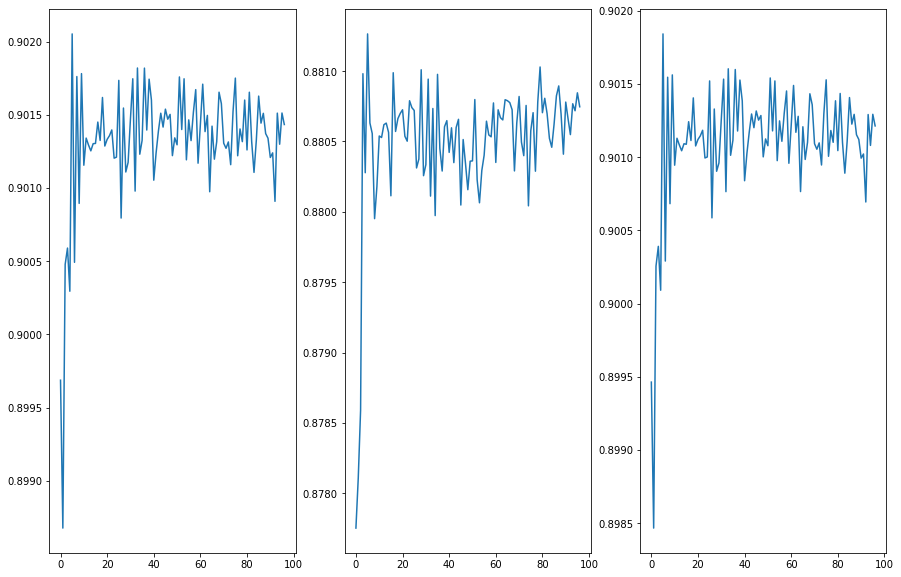

In [53]:
optimise_n(d,l,KNeighborsClassifier(),nmax=100)

Best average precision : 0.8647984707945587 with n = 89
Best average recall : 0.885735799751211 with n = 31
Best average f_beta : 0.864939141498581 with n = 89


(array([0.        , 0.        , 0.        , 0.8617431 , 0.86262511,
        0.86329268, 0.86247026, 0.86140481, 0.86251997, 0.8634924 ,
        0.8634385 , 0.86371761, 0.86405841, 0.86388235, 0.86290506,
        0.86316838, 0.86317261, 0.8636479 , 0.86302667, 0.86207544,
        0.86315662, 0.86371529, 0.86252983, 0.86193832, 0.8629455 ,
        0.86410129, 0.86193034, 0.86130124, 0.86240801, 0.86301957,
        0.86398103, 0.85991355, 0.86345142, 0.86333091, 0.86290256,
        0.86387072, 0.86408907, 0.86330996, 0.86206275, 0.86378844,
        0.86317138, 0.8633261 , 0.86278029, 0.86333069, 0.86339574,
        0.86263204, 0.8620361 , 0.86132568, 0.86421278, 0.86218692,
        0.86325639, 0.86415598, 0.86146463, 0.86020938, 0.8645833 ,
        0.86347577, 0.86261324, 0.86314739, 0.86418364, 0.86326808,
        0.86317392, 0.8624037 , 0.86358692, 0.86158129, 0.86264822,
        0.86275258, 0.86272931, 0.86149775, 0.86269883, 0.86307225,
        0.86179303, 0.86431068, 0.86306141, 0.86

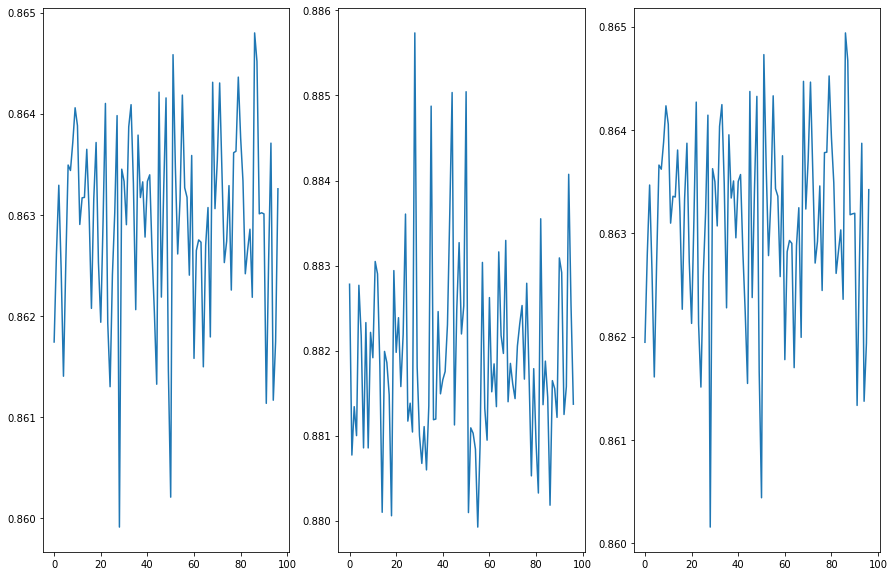

In [55]:
optimise_n(d,l,RandomForestClassifier(max_depth=2, random_state=0),nmax=100)

Best average precision : 0.8878382758360025 with n = 12
Best average recall : 0.7837846662171799 with n = 43
Best average f_beta : 0.886670060966941 with n = 12


(array([0.        , 0.        , 0.        , 0.88744765, 0.88752114,
        0.88775358, 0.88744671, 0.88759991, 0.88735639, 0.88725635,
        0.88732182, 0.88740846, 0.88783828, 0.88746771, 0.88749302,
        0.88757077, 0.88735614, 0.8873095 , 0.88743194, 0.88740036,
        0.88762009, 0.88742391, 0.88733214, 0.88755949, 0.88756074,
        0.88740159, 0.88729376, 0.88736075, 0.8875785 , 0.88738819,
        0.88734796, 0.88737571, 0.88757964, 0.88734301, 0.88736465,
        0.88721124, 0.88756633, 0.88749401, 0.88732467, 0.88745497,
        0.88731323, 0.88761271, 0.88735999, 0.887466  , 0.88737488,
        0.88767998, 0.88752886, 0.88767385, 0.88737037, 0.88767352,
        0.88740696, 0.88744015, 0.88741154, 0.88743615, 0.88739922,
        0.88750142, 0.88754929, 0.88743432, 0.88729643, 0.88729402,
        0.88726299, 0.88736888, 0.88742586, 0.88734783, 0.88744564,
        0.88731252, 0.88728733, 0.88733004, 0.88747864, 0.88761838,
        0.88718387, 0.88745045, 0.88733578, 0.88

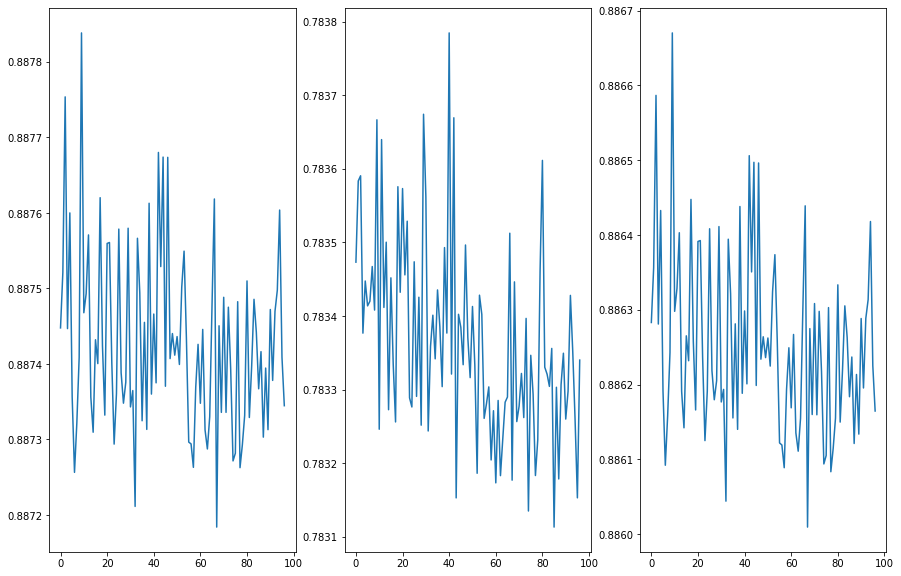

In [56]:
optimise_n(d,l,GaussianNB(),nmax=100)

In [111]:
cross_validation_data,cross_validation_labels = data_splitting(d,l,8)
precisions,recalls,f_betas,auc_values_knn,fp_rates_knn,tp_rates_knn,t_knn = cross_validation(cross_validation_data,cross_validation_labels,KNeighborsClassifier())
auc_values_knn_mean,auc_values_knn_std = np.mean(auc_values_knn),np.std(auc_values_knn)
print_quality_params(precisions,recalls,f_betas,auc_values_knn,'KNeighbors')

Quality parameters obtained using the KNeighbors classifier :
Precision averaged : 0.9430706006385432 ± 0.00409771854897732
Recall averaged : 0.8158907573345262 ± 0.007102785202541125
f_beta averaged : 0.9416164179762054 ± 0.004054634519132563
AUC averaged : 0.9450148871237292 ± 0.002764169527145672


In [110]:
cross_validation_data,cross_validation_labels = data_splitting(d,l,89)
precisions,recalls,f_betas,auc_values_rf,fp_rates_rf,tp_rates_rf,t_rf = cross_validation(cross_validation_data,cross_validation_labels,RandomForestClassifier(max_depth=2, random_state=0))
auc_values_rf_mean,auc_values_rf_std = np.mean(auc_values_rf),np.std(auc_values_rf)
print_quality_params(precisions,recalls,f_betas,auc_values_rf,'RandomForest')

Quality parameters obtained using the RandomForest classifier :
Precision averaged : 0.9521862978912499 ± 0.01703108566091955
Recall averaged : 0.7318788747081063 ± 0.03280156066578755
f_beta averaged : 0.9493347667318206 ± 0.01694653890400861
AUC averaged : 0.9507675691548733 ± 0.00940918250476447


In [112]:
cross_validation_data,cross_validation_labels = data_splitting(d,l,12)
precisions,recalls,f_betas,auc_values_nb,fp_rates_nb,tp_rates_nb,t_nb = cross_validation(cross_validation_data,cross_validation_labels,GaussianNB())
auc_values_nb_mean,auc_values_nb_std = np.mean(auc_values_nb),np.std(auc_values_nb)
print_quality_params(precisions,recalls,f_betas,auc_values_nb,'NaiveBayes')

Quality parameters obtained using the NaiveBayes classifier :
Precision averaged : 0.8984894128085864 ± 0.010911221362110266
Recall averaged : 0.7459967633504826 ± 0.00830894980060888
f_beta averaged : 0.8966731940190374 ± 0.010819257779881965
AUC averaged : 0.9291818062550029 ± 0.0037711645072776513


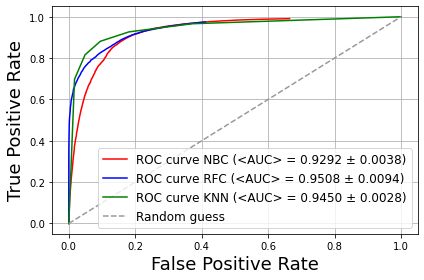

In [70]:
#plt.figure(figsize=(15,10))
#plt.rcParams.update({'font.size': 15})
plt.plot(fp_rates_nb,tp_rates_nb,color='red',label='ROC curve NBC (<AUC> = %0.4f ± %0.4f)'%(auc_values_nb_mean,auc_values_nb_std))
plt.plot(fp_rates_rf,tp_rates_rf,color='blue',label='ROC curve RFC (<AUC> = %0.4f ± %0.4f)'%(auc_values_rf_mean,auc_values_rf_std))
plt.plot(fp_rates_knn,tp_rates_knn,color='green',label='ROC curve KNN (<AUC> = %0.4f ± %0.4f)'%(auc_values_knn_mean,auc_values_knn_std))
plt.xlabel('False Positive Rate',fontsize=18)
plt.ylabel('True Positive Rate',fontsize=18)
plt.plot([0, 1],[0, 1],linestyle='--',color=(0.6, 0.6, 0.6),label='Random guess')
plt.grid()
plt.legend(loc="best",fontsize='large')
plt.tight_layout()

In [113]:
test_data = pd.read_csv('Data/test.csv').dropna(axis=1)
remove_labels = [k for k in test_data.columns if 'Weight' in k or 'MC' in k or 'Corsika' in k or 'I3EventHeader' in k]
test_data = test_data.drop(remove_labels, axis=1)
test_data = test_data.fillna(-1e30)
test_data = test_data[mRMR_features]
print(test_data.shape)

(4000, 7)


In [114]:
clf = KNeighborsClassifier()
clf.fit(train, labels)
probs = clf.predict_proba(test_data)
KNN_preds = (probs[:, 1] >= 0.8).astype(int)

In [115]:
predictions = pd.DataFrame(KNN_preds,columns=['label'])
predictions.to_csv('Data/predicted_test_labels.csv',index=False)